In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import bitdotio

#sns.set(font_scale=1.5, style='whitegrid')
#plt.rcParams["font.family"] = "sans serif"
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 100)

# Enter your bit.io API key here
# **CAUTION**: Move your API key to an ENV variable or read in from a file if you will be sharing this code publicly
API_KEY = '<ENTER YOUR bit.io API key here>'

# Style configuration
COLORS = [
    '#0059ff',
    '#fdbd28',
    '#28D9AA',
    '#EE5149',
    '#060F41',
    '#788995',
    '#FF69B4',
    '#7F00FF',
]
GREY = '#788995'
DARK_GREY = '#060F41'
BLUE = '#0059ff'
DBLUE = '#060F41'
GOLD = '#fdbd28'
GREEN = '#28D9AA'
RED = '#EE5149'
BLACK = '#000000'
WHITE = '#FFFFFF'
LINEWIDTH = 3
LINESPACING = 1.25
FS_SUPTITLE = 30
FS_CAPTION = 24
FS_LABEL = 24
FS_FOOTNOTE = 20

#### Download the dataset from bit.io

In [2]:
sql = '''
SELECT *
FROM "bitdotio/nfl_combine"."2021_combine_and_draft";
'''

def connect_bitdotio(key):
    '''Get a psycopg2 connection to bit.io'''
    # Connect to bit.io
    b = bitdotio.bitdotio(key)
    # Get psycopg2 connection
    return b.get_connection()  

def pandas_query_bitdotio(key, sql):
    '''Query bit.io and return a pandas dataframe'''
    try:
        # Connect to bit.io
        conn = connect_bitdotio(key)
        # Execute sql
        return pd.read_sql(sql, conn)
    except (Exception) as e:
        print(e)
    finally:
        if conn is not None:
            conn.close()
            
df = pandas_query_bitdotio(API_KEY, sql)
df.head()

,year,name,college,position,height_in,weight_lb,40_yard,bench_press,vert_leap_in,broad_jump_in,shuttle,3_cone,draft_round
0,2021,Jonathan Adams,Arkansas State,WR,74.00,210,4.59,NaN,39.0,132,4.38,7.04,NaN
1,2021,Paulson Adebo,Stanford,CB,73.00,198,4.45,18.0,36.5,121,4.13,6.69,NaN
2,2021,DAngelo Amos,Virginia,FS,71.75,191,4.58,11.0,34.5,119,4.33,6.98,NaN
3,2021,Jack Anderson,Texas Tech,OG,76.63,314,5.27,27.0,29.5,105,4.83,7.88,NaN
4,2021,Otis Anderson,Central Florida,RB,67.50,179,4.65,11.0,36.0,113,4.42,7.04,NaN


#### Data Prep

In [3]:
# Define study dimensions
feats = [
    'height_in',
    'weight_lb',
    '40_yard',
    'bench_press',
    'vert_leap_in',
    'broad_jump_in',
    'shuttle',
    '3_cone',  
]

# Feature display names for plots
name_map = {'height_in': 'Height',
            'weight_lb': 'Weight',
            '40_yard': '40 yard',
            'bench_press': 'Bench\nPress',
            'vert_leap_in': 'Vertical\nLeap',
            'broad_jump_in': 'Broad\nJump',
            'shuttle': 'Shuttle',
            '3_cone': 'Three\nCone'}


# Simplify positions for plotting clarity
pos_map = {
    'WR': 'Receiver',
    'CB': 'Defensive Back',
    'RB': 'Offensive Back',
    'OT': 'Offensive Line',
    'DE': 'Defensive Line',
    'OG': 'Offensive Line',
    'DT': 'Defensive Line',
    'OLB': 'Line Backer',
    'SS': 'Defensive Back',
    'ILB': 'Linebacker',
    'TE': 'Tight End',
    'FS': 'Defensive Back',
    'C': 'Offensive Line',
    'FB': 'Offensive Back'
}

df['merge_pos'] = df['position'].map(pos_map)

# Dropping athletes missing any of eight studied dimensions or mapped positions
df = df.dropna(subset=feats + ['merge_pos']).copy()

#### Pairwise scatterplots (qualitative without axes)

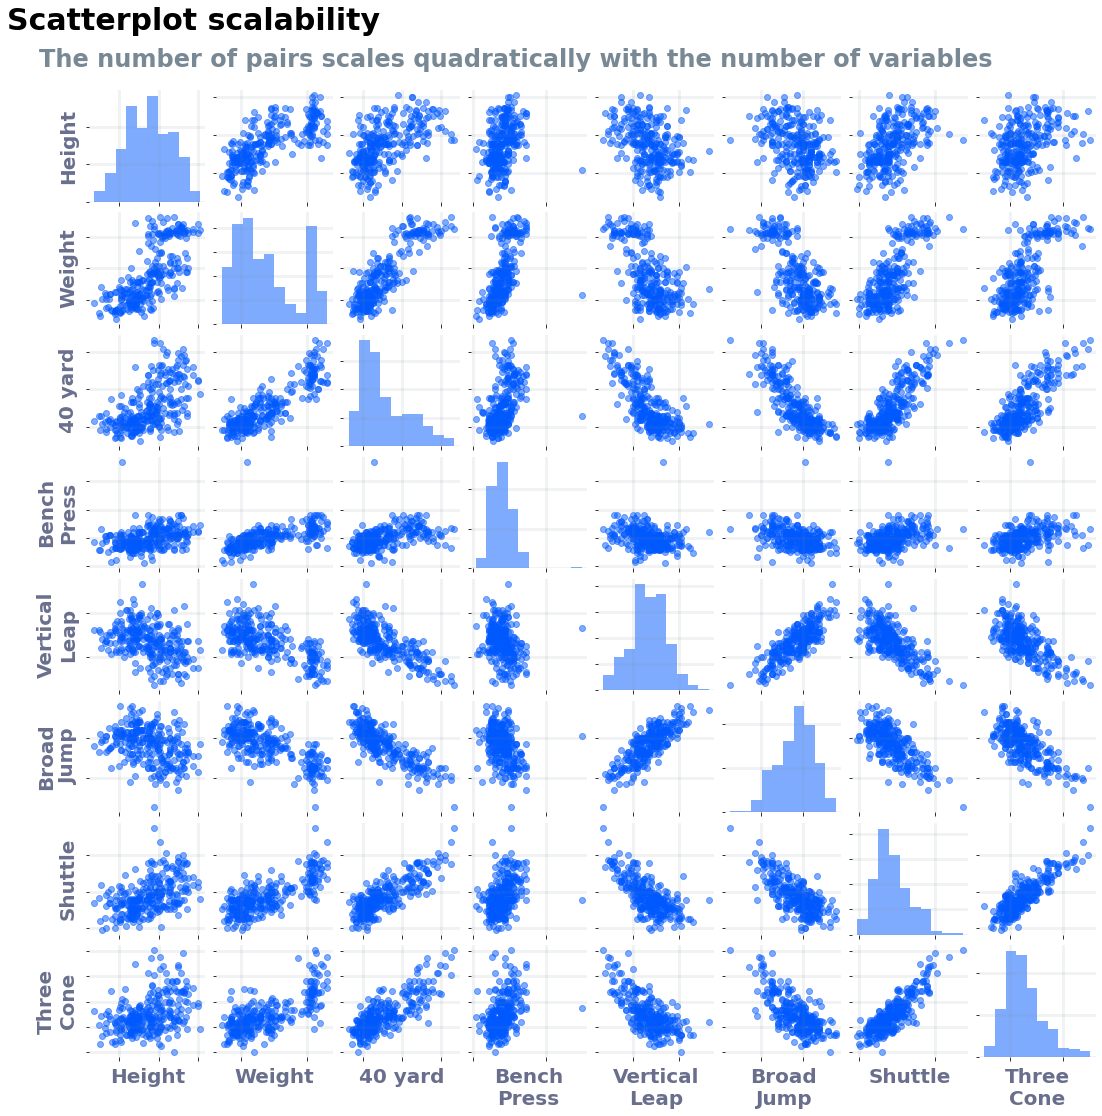

In [4]:
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
for i, feat1 in enumerate(feats):
    for j, feat2 in enumerate(feats):
        # Plot histograms on diagonal
        if feat1 == feat2:
            ax[i][j].hist(df[feat1], color=BLUE, density=True, alpha=0.5)
        # Otherwise plot scatterplots
        else:
            ax[i][j].scatter(df[feat2], df[feat1], color=BLUE, alpha=0.5)
        if i == len(feats) - 1:
            ax[i][j].set_xlabel(name_map[feat2], fontweight='bold', fontsize=FS_FOOTNOTE, color=DARK_GREY, alpha=0.6)
        if j == 0:
            ax[i][j].set_ylabel(name_map[feat1], fontweight='bold', fontsize=FS_FOOTNOTE, color=DARK_GREY, alpha=0.6)
        # Style axes
        ax[i][j].set_xticklabels([])
        ax[i][j].set_yticklabels([])
        ax[i][j].grid(b=True, color=GREY, alpha=0.1, linewidth=3)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax[i][j].spines[spine].set_visible(False)
            ax[i][j].spines[spine].set_visible(False)
            
# Figure level styling
fig.suptitle('Scatterplot scalability', x=0.155, y=1.03, fontweight='bold', fontsize=FS_SUPTITLE)
fig.text(0.012, 0.975, 'The number of pairs scales quadratically with the number of variables', fontweight='bold', color=GREY, fontsize=FS_CAPTION)
fig.tight_layout()
plt.show() 

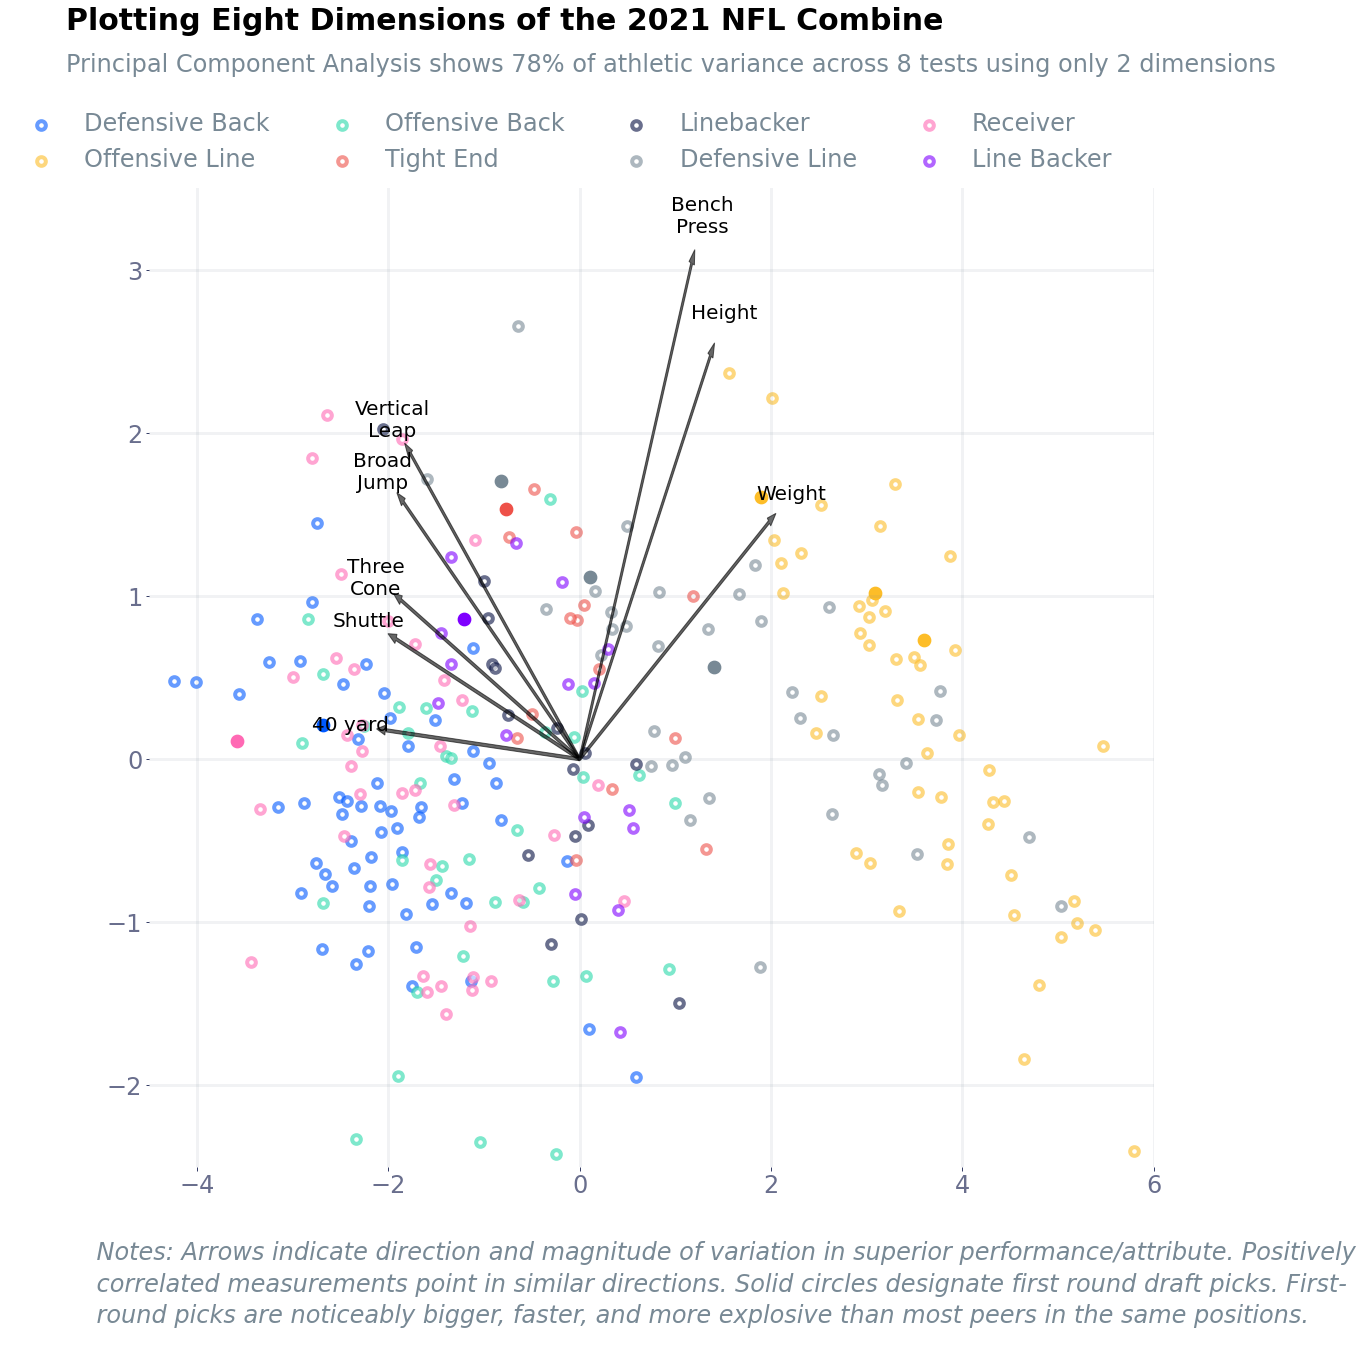

In [5]:
# Filter to feature set
df_temp = df[feats].copy()

# Make larger value "better" for all variables for more intuitive vectors
# This requires negating timed events where larger value is otherwise "worse"
for col in ['40_yard', 'shuttle', '3_cone']:
    df_temp[col] = -1 * df_temp[col]
    
# Standardize features   
ss = StandardScaler()
X = ss.fit_transform(df_temp.values)

# Compute principal components and transform features
pca = PCA()
pca.fit(X)
# Note: we fit on a subset, but need to transform all the data
X = pca.transform(X)

# Add principal components to the dataset for plotting
df['pc1'] = X[:,0]
df['pc2'] = X[:,1]

fig, ax = plt.subplots(figsize=(18, 18))
# Iterate over all positions and plot with distinct colors
for i, pos in enumerate(df['merge_pos'].unique()):
    # Plot athletes who were not drafted in first round
    df_temp1 = df.loc[(df['merge_pos'] == pos) & (~df['draft_round'].isin([1]))].copy()
    ax.scatter(df_temp1['pc1'], df_temp1['pc2'], s=75, label=pos, marker='o', color=COLORS[i], linewidths=4, facecolor=WHITE, alpha=0.6)
    
    # Plot athletes who were drafted in first round
    df_temp2 = df.loc[(df['merge_pos'] == pos) & (df['draft_round'].isin([1]))].copy()
    ax.scatter(df_temp2['pc1'], df_temp2['pc2'], alpha=1.0, s=95, marker='o', color=COLORS[i], linewidths=4)
    
# Plot loadings of the principal components as projected features
comps = pca.components_
comp_weights = list(zip(feats, comps[0,:], comps[1,:]))
scaler = 5 # Basically a shimming factor for how long you want to make the arrows
x_offset, y_offset = 0.4, 0.4 # You can customize these using a map from the features instead
for feat, x, y in comp_weights:
    ax.arrow(0, 0, scaler*x, scaler*y, color='k', width=0.02, alpha=0.6)
    ax.text(scaler*x + x_offset * np.sign(x) * (np.abs(x) / (np.abs(y) + np.abs(x))),
            scaler*y + y_offset * np.sign(y) * np.abs(y) / (np.abs(x) + np.abs(y)),
            name_map[feat],
            ha='center',
            va='center',
            color='k',
            alpha=1.0,
            fontsize=FS_FOOTNOTE)
    
# Style the axes further
for i in range(2):
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)
ax.grid(b=True, color=GREY, alpha=0.1, linewidth=3)
ax.tick_params(colors=DARK_GREY, labelsize=FS_LABEL, which='both')
plt.setp(ax.get_xticklabels(), alpha=0.6)
plt.setp(ax.get_yticklabels(), alpha=0.6)
ax.set(xlim=(-4.5, 6), ylim=(-2.5, 3.5))
ax.legend(bbox_to_anchor=(0.413, 1.1), ncol=4, loc='upper center', fontsize=FS_LABEL, facecolor='white', frameon=False, labelcolor=GREY)

# Style the figure
fig.suptitle('Plotting Eight Dimensions of the 2021 NFL Combine', x=0.061, y=1.02, ha='left', fontweight='bold', fontsize=FS_SUPTITLE, color='k')
fig.text(0.061, 0.97, 'Principal Component Analysis shows 78% of athletic variance across 8 tests using only 2 dimensions', fontsize=FS_CAPTION, color=GREY)
caption = '''
    Notes: Arrows indicate direction and magnitude of variation in superior performance/attribute. Positively
    correlated measurements point in similar directions. Solid circles designate first round draft picks. First-
    round picks are noticeably bigger, faster, and more explosive than most peers in the same positions.
    '''
fig.text(0.061, -0.02, caption, fontsize=FS_CAPTION, color=GREY, linespacing=1.4, fontstyle='italic')
plt.show()

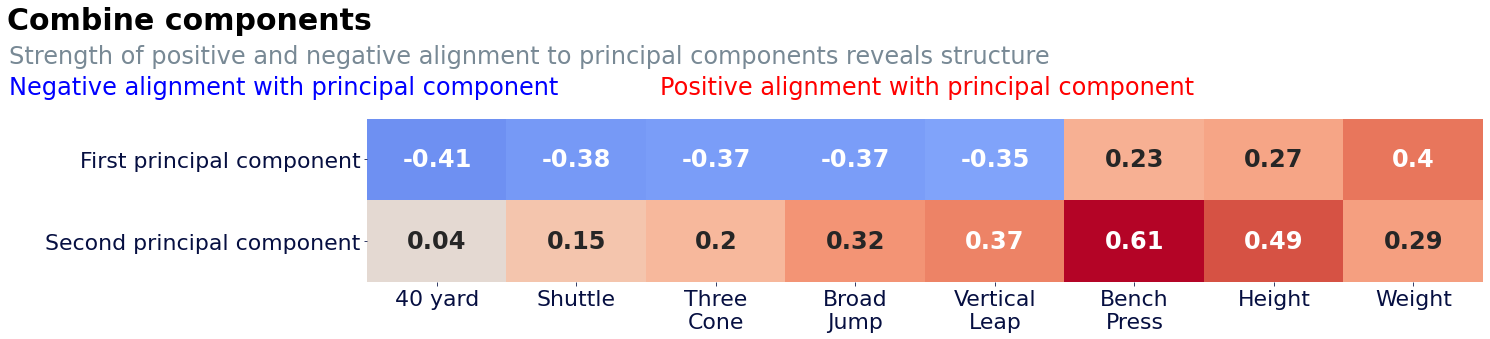

In [6]:
# Plot the loadings as a heat map
df_temp = pd.DataFrame(data=pca.components_[0:2,:],
                       columns=[name_map[feat] for feat in feats],
                       index=['First principal component', 'Second principal component'])

# Plot heatmap, using a default colormap to remove excessive matplotlib complexity
min_num = df_temp.min().min()
max_num = df_temp.max().max()
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(df_temp.rename(columns=name_map).T.sort_values('First principal component').T.round(2), cmap='coolwarm', center=0,
            ax=ax, annot=True, annot_kws={'fontsize': FS_LABEL, 'fontweight': 'bold'}, cbar=False)

# Format axes
plt.xticks(rotation=0)
ax.tick_params(colors=DARK_GREY, labelsize=FS_LABEL - 2, which='both')
fig.suptitle('Combine components', x=-0.125, y=1.4, ha='left', fontweight='bold', fontsize=FS_SUPTITLE)
ax.text(-2.57, -0.685, 'Strength of positive and negative alignment to principal components reveals structure', fontsize=FS_LABEL, color=GREY)
ax.text(-2.57, -0.3, 'Negative alignment with principal component', color='blue', fontsize=FS_LABEL)
ax.text(2.1, -0.3, 'Positive alignment with principal component', color='red', fontsize=FS_LABEL)
plt.show()

#### Finally, PCA plot variance explained vs. null variance

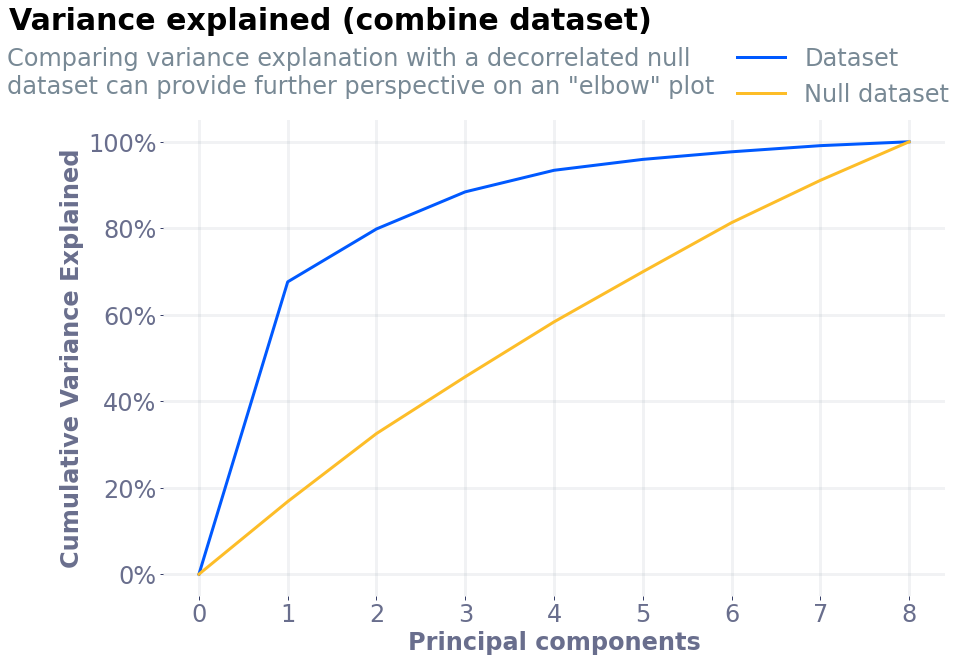

In [7]:
# Plot variance explained
fig, ax = plt.subplots(figsize=(14, 14/1.6))
n = pca.n_components_
       
# Plot variance explained for the dataset
ax.plot([i for i in range(n+1)], [0] + list(pca.explained_variance_ratio_.cumsum()), label='Dataset', color=COLORS[0], linewidth=LINEWIDTH)

# Null out all correlations, fit null PCA
df_temp = df[feats].copy()  
ss = StandardScaler()
X = ss.fit_transform(df_temp.values)
for i in range(X.shape[1]):
    np.random.shuffle(X[:,i])
pca_null = PCA().fit(X)

# Plot null PCA and style axes
ax.plot([i for i in range(n+1)], [0] + list(pca_null.explained_variance_ratio_.cumsum()), label='Null dataset', color=COLORS[1], linewidth=LINEWIDTH)
ax.set_xticks([i for i in range(n + 1)])
ax.set_xticklabels([f'{i}' for i in range(n + 1)])
ax.set_xlabel(xlabel='Principal components', color=DARK_GREY, alpha=0.6, fontsize=FS_LABEL, fontweight='bold')
ax.set_ylabel(ylabel='Cumulative Variance Explained', color=DARK_GREY, alpha=0.6, fontsize=FS_LABEL, fontweight='bold')
ax.grid(b=True, color=GREY, alpha=0.1, linewidth=3)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.tick_params(colors=DARK_GREY, labelsize=FS_LABEL, which='both')
plt.setp(ax.get_xticklabels(), alpha=0.6)
plt.setp(ax.get_yticklabels(), alpha=0.6)
ax.set_yticks([0.0, 0.2, 0.4,0.6, 0.8, 1.0])
ax.set_yticklabels([str(num) + '%' for num in [0, 20, 40, 60, 80, 100]], color=DARK_GREY, fontsize=FS_LABEL, alpha=0.6)
ax.legend(bbox_to_anchor=(0.87, 1.2), ncol=1, loc='upper center', fontsize=FS_LABEL, facecolor='white', frameon=False, labelcolor=GREY)

# Style figure
fig.suptitle('Variance explained (combine dataset)', x=0.291, y=1.06, fontweight='bold', fontsize=FS_SUPTITLE)
fig.text(-0.03, 0.923, 'Comparing variance explanation with a decorrelated null\ndataset can provide further perspective on an "elbow" plot', fontsize=FS_CAPTION, color=GREY)
plt.show()